# Multi-round inference

In the previous tutorials, we have inferred the posterior using **single-round inference**. In **single-round inference**, we draw parameters from the prior, simulate them, and then train a neural network to estimate the posterior. However, sampling from the prior can be inefficient in the number of simulations. In this tutorial, we show how one can alleviate this issue by performing **multi-round inference** with `sbi`.  

**Multi-round inference** also starts by drawing parameters from the prior, simulating them, and training a neural network to estimate the posterior distribution. After this, it draws samples from the obtained posterior distribution, simulates these, and trains the network again. This process can be repeated arbitrarily often to get increasingly good approximations to the true posterior distribution.

Running multi-round inference can be more efficient in the number of simulations, but it will lead to the posterior no longer being amortized (i.e. it will be accurate only for a specific observation `x_o`, not for any `x`).

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorial/03_multiround_inference.ipynb](https://github.com/mackelab/sbi/blob/main/tutorial/03_multiround_inference.ipynb) in the `sbi` repository.

## Main syntax

In [ ]:
num_rounds = 2  # 2 rounds: first round simulates from the prior, second round simulates from the obtained posterior.
x_o = torch.zeros(3,)

posteriors = []
proposal = None

for _ in range(num_rounds):
    posterior = inference(num_simulations=500, proposal=proposal)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

## Linear Gaussian example
Below, we give a full example of inferring the posterior distribution over multiple rounds.

In [1]:
import torch

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import sbi.utils as utils

First, we define a simple prior and simulator and ensure that they comply with `sbi` by using `prepare_for_sbi`:

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [4]:
simulator, prior = prepare_for_sbi(linear_gaussian, prior)

Then, we instantiate the inference object:

In [5]:
inference = SNPE(simulator, prior)

And we can run inference. In this example, we will run inference over `2` rounds, potentially leading to a more focused posterior around the observation `x_o`.

In [6]:
num_rounds = 2
x_o = torch.zeros(3,)

posteriors = []
proposal = None

for _ in range(num_rounds):
    posterior = inference(num_simulations=500, proposal=proposal)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)


Neural network successfully converged after 152 epochs.
Using SNPE-C with atomic loss



Neural network successfully converged after 32 epochs.


 Note that, for `num_rounds>1`, the posterior is no longer amortized: it will give good results when sampled around `x=observation`, but possibly bad results for other `x`.

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

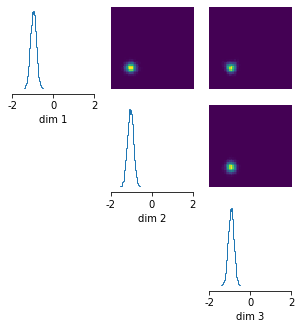

In [7]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = utils.pairplot(posterior_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))

We can always print the posterior to know how it was trained:

In [8]:
print(posterior)

Posterior conditional density p(θ|x) (multi-round). Evaluates and samples by default at x=[[0.0, 0.0, 0.0]].

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.
